In [43]:
import sklearn.cluster
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import time
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM

fontsize = 18

def compute_metrics_for_dataset(paths, method, parameters):
    history = {"parameters": parameters, "ct": [0,]*len(parameters), "cf": [0,]*len(parameters), "psnr": [0,]*len(parameters), "ssim": [0,]*len(parameters)}
    for i, parameter in enumerate(parameters):
        for path in paths:
            img = Image.open(path) 
            grey_img = np.array(img.convert("L"))

            t = time.perf_counter()
            comp_img, cf = method(grey_img, parameter)
            t = time.perf_counter() - t

            history["ct"][i] += t
            history["cf"][i] += cf
            history["psnr"][i] += PSNR(grey_img, comp_img)
            history["ssim"][i] += SSIM(grey_img, comp_img)
        history["ct"][i] /= len(parameters)
        history["cf"][i] /= len(parameters)
        history["psnr"][i] /= len(parameters)
        history["ssim"][i] /= len(parameters)
    return history

def vector_quantization(img, num_clusters): # num_clusters = 2, 4, 8, 16, 32, 64, 128, 256
    X = img.reshape((-1, 1))
    kmeans = sklearn.cluster.KMeans(num_clusters)
    kmeans.fit(X)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    X_quantized = centroids[labels]
    comp_img = X_quantized.reshape(img.shape).astype(np.uint8)
    
    cf = 8/np.log2(num_clusters)
    return comp_img, cf

def scalar_quantization(img, n_bits): # [1-8] (sugested 1, 2, 4, 8)
    cf = 8/n_bits
    coef = 2**(8-n_bits)
    comp_img = (img // coef * coef).astype(np.uint8)
    return comp_img, cf

In [20]:
img = Image.open('../../data/other/lenna.png') 
grey_img = np.array(img.convert("L"))

# Scalar Quantization

In [15]:
num_bits_ = [8, 7, 6, 5, 4, 3, 2, 1]

history = {"num_bits": [],"comp_img":[], "ct": [], "cf": [], "psnr": [], "ssim": []}
for num_bits in num_bits_:
    t = time.perf_counter()
    comp_img, cf = scalar_quantization(grey_img, num_bits)
    t = time.perf_counter() - t
    history["num_bits"].append(num_bits)
    history["comp_img"].append(comp_img)
    history["ct"].append(t)
    history["cf"].append(cf)
    history["psnr"].append(PSNR(grey_img, comp_img))
    history["ssim"].append(SSIM(grey_img, comp_img))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


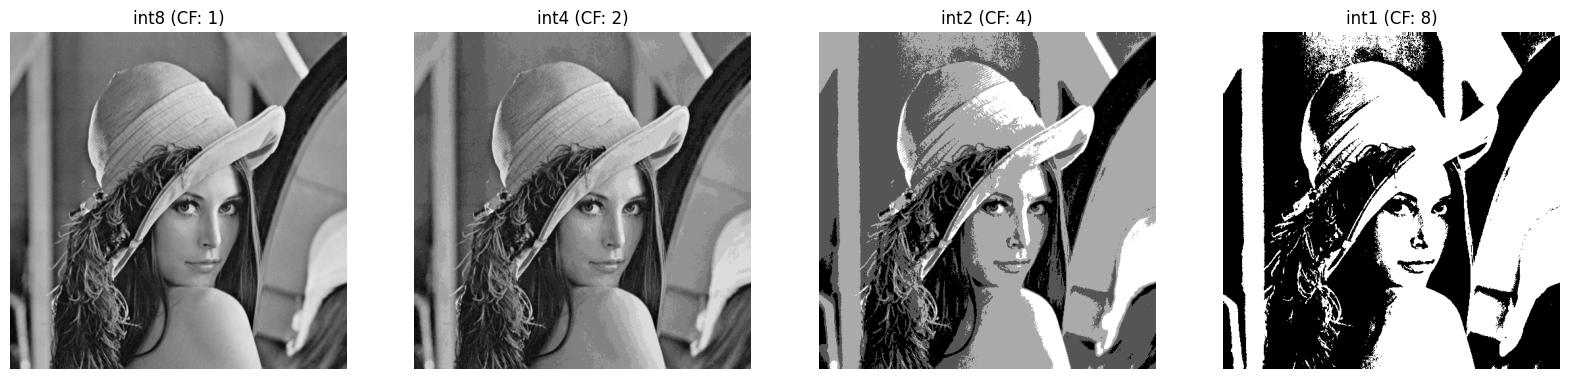

In [16]:
plot_num_bits_ = [8, 4, 2, 1]

fig, ax_= plt.subplots(1, len(plot_num_bits_), figsize=(20, 20))
for i, ax in enumerate(ax_):
    idx = history["num_bits"].index(plot_num_bits_[i])
    ax.imshow(history["comp_img"][idx], cmap='gray')
    ax.set_title(f'int{history["num_bits"][idx]} (CF: {int(history["cf"][idx])})')
    ax.axis("off")

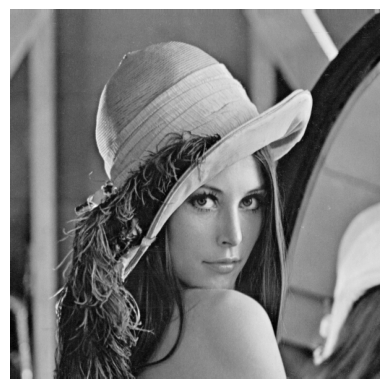

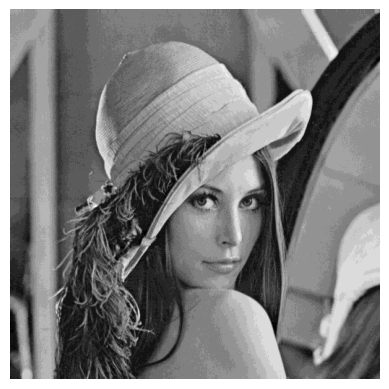

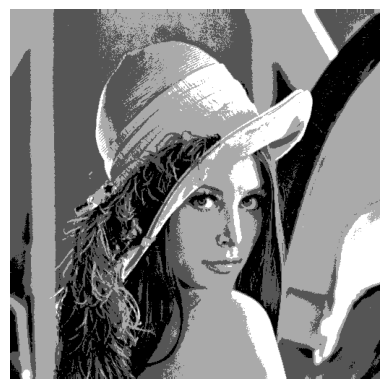

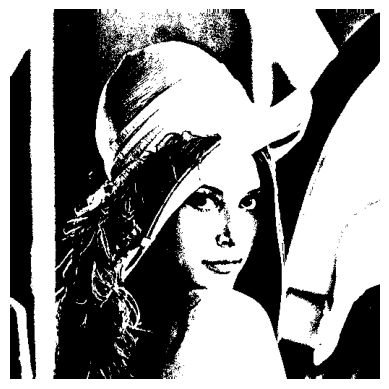

In [17]:
plot_num_bits_ = [8, 4, 2, 1]

for i, ax in enumerate(ax_):
    idx = history["num_bits"].index(plot_num_bits_[i])
    plt.imshow(history["comp_img"][idx], cmap='gray')
    # plt.title(f'int{history["num_bits"][idx]} (CF: {int(history["cf"][idx])})')
    plt.axis("off")
    plt.show()

In [40]:
import os
dir_path = "../../data/CUSTOM"
paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]

num_bits_ = [8, 7, 6, 5, 4, 3, 2, 1]
history = compute_metrics_for_dataset(paths, scalar_quantization, num_bits_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


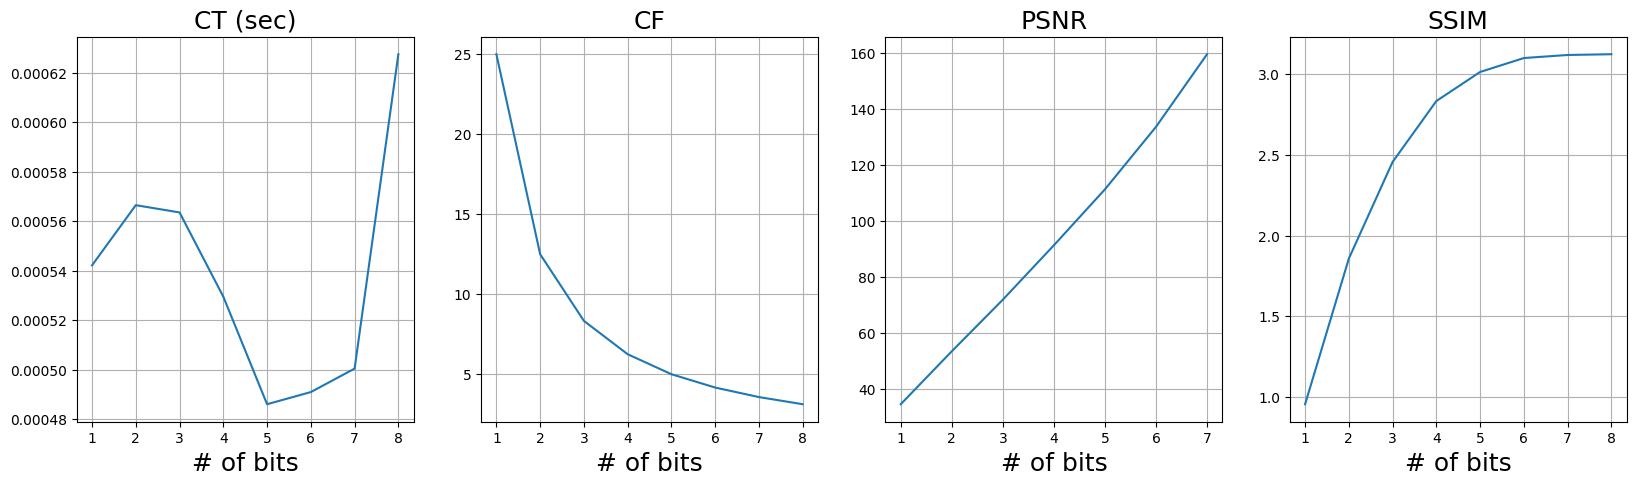

In [42]:
fontsize=18

fig, ax_= plt.subplots(1, 4, figsize=(20, 5))
for metric, ax in zip(["ct", "cf", "psnr", "ssim"], ax_):
    ax.plot(history["parameters"], history[metric])
    ax.set_xlabel(f"# of bits", fontsize=fontsize)
    if metric == "ct":
        ax.set_title(f"{metric.upper()} (sec)", fontsize=fontsize)
    else:
        ax.set_title(f"{metric.upper()}", fontsize=fontsize)
    ax.grid(True)

# Vector Quantization

In [48]:
num_clusters_ = [256, 128, 64, 32, 16, 8, 4, 2]

history = {"num_clusters": [],"comp_img":[], "ct": [], "cf": [], "psnr": [], "ssim": []}
for num_clusters in num_clusters_:
    t = time.perf_counter()
    comp_img, cf = vector_quantization(grey_img, num_clusters)
    t = time.perf_counter() - t
    history["num_clusters"].append(num_clusters)
    history["comp_img"].append(comp_img)
    history["ct"].append(t)
    history["cf"].append(cf)
    history["psnr"].append(PSNR(grey_img, comp_img))
    history["ssim"].append(SSIM(grey_img, comp_img))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (215) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


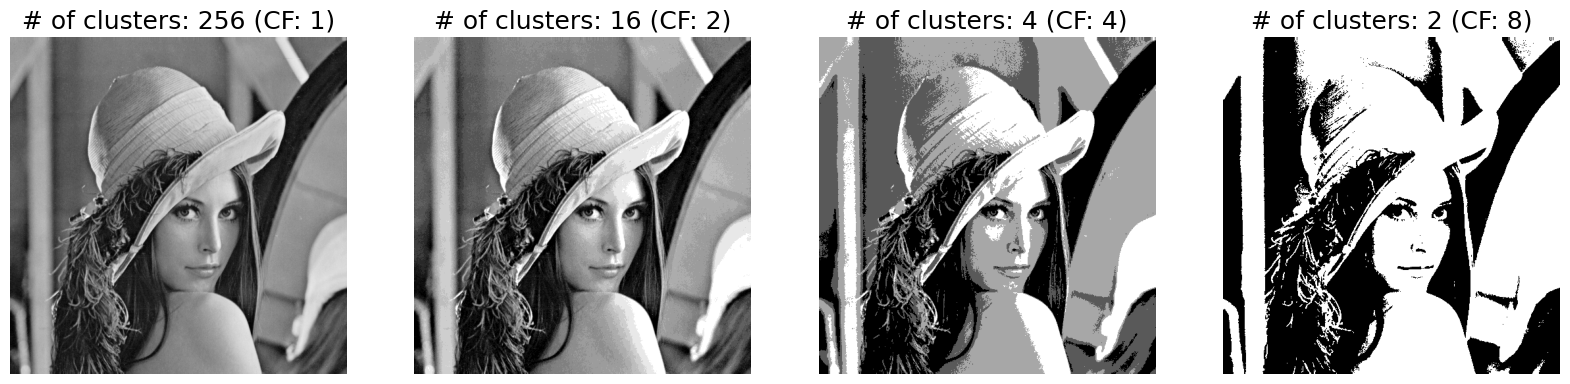

In [49]:
plot_num_clusters_ = [256, 16, 4, 2]

fig, ax_= plt.subplots(1, len(plot_num_clusters_), figsize=(20, 20))
for i, ax in enumerate(ax_):
    idx = history["num_clusters"].index(plot_num_clusters_[i])
    ax.imshow(history["comp_img"][idx], cmap='gray')
    ax.set_title(f'# of clusters: {history["num_clusters"][idx]} (CF: {int(history["cf"][idx])})', fontsize=fontsize)
    ax.axis("off")

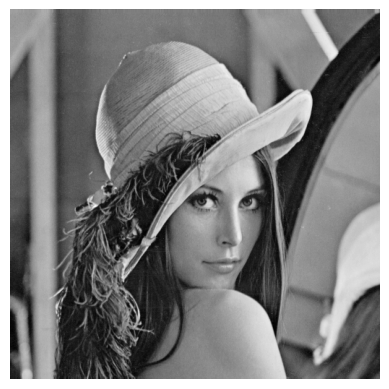

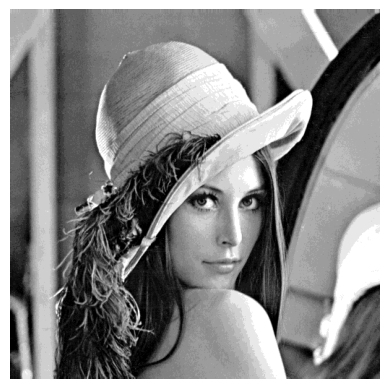

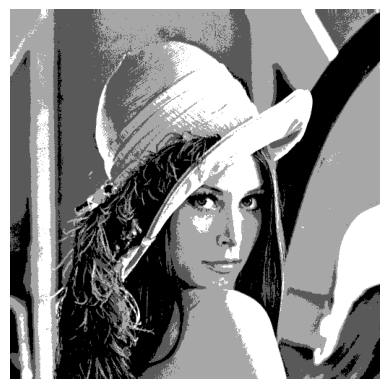

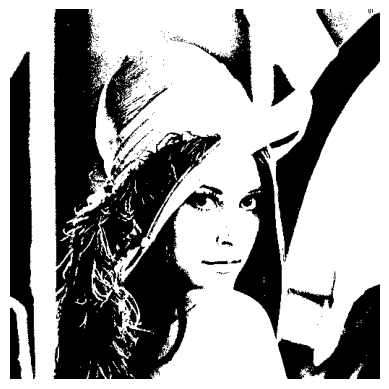

In [50]:
plot_num_clusters_ = [256, 16, 4, 2]

for i, ax in enumerate(ax_):
    idx = history["num_clusters"].index(plot_num_clusters_[i])
    plt.imshow(history["comp_img"][idx], cmap='gray')
    plt.axis("off")
    plt.show()

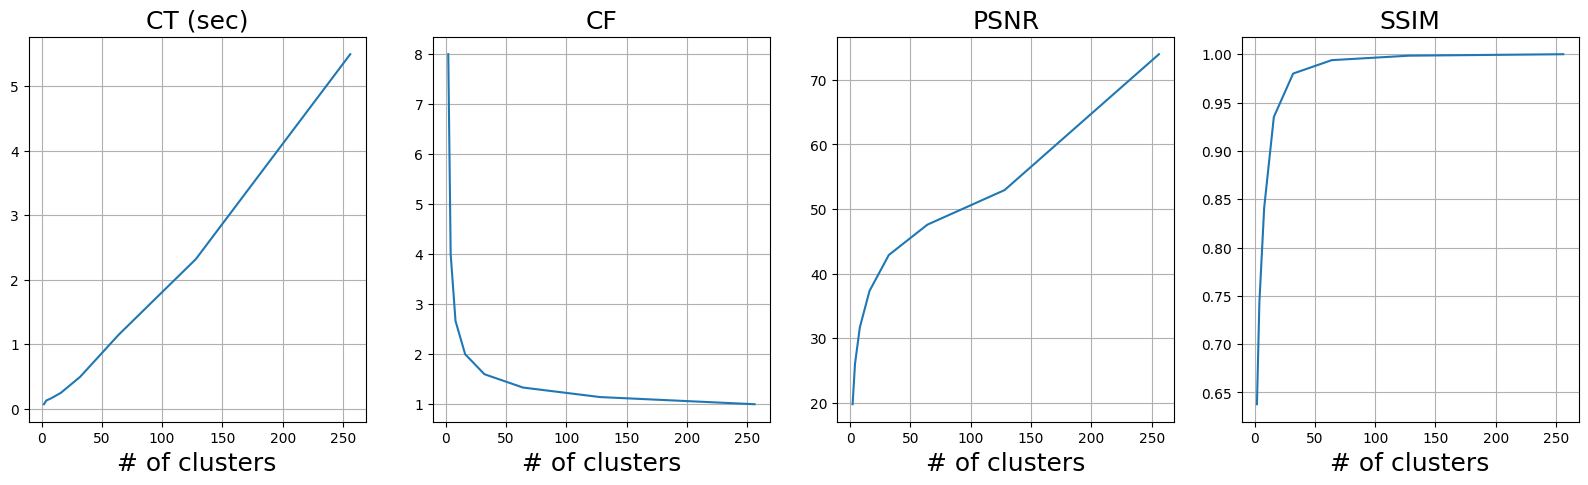

In [51]:
fontsize = 18

fig, ax_= plt.subplots(1, 4, figsize=(20, 5))
for metric, ax in zip(["ct", "cf", "psnr", "ssim"], ax_):
    ax.plot(history["num_clusters"], history[metric])
    ax.set_xlabel("# of clusters", fontsize=fontsize)
    if metric == "ct":
        ax.set_title(f"{metric.upper()} (sec)", fontsize=fontsize)
    else:
        ax.set_title(f"{metric.upper()}", fontsize=fontsize)
    ax.grid(True)

In [52]:
import os
dir_path = "../../data/CUSTOM"
paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]

num_clusters_ = [256, 128, 64, 32, 16, 8, 4, 2]
history = compute_metrics_for_dataset(paths, vector_quantization, num_clusters_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (253) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (64) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered

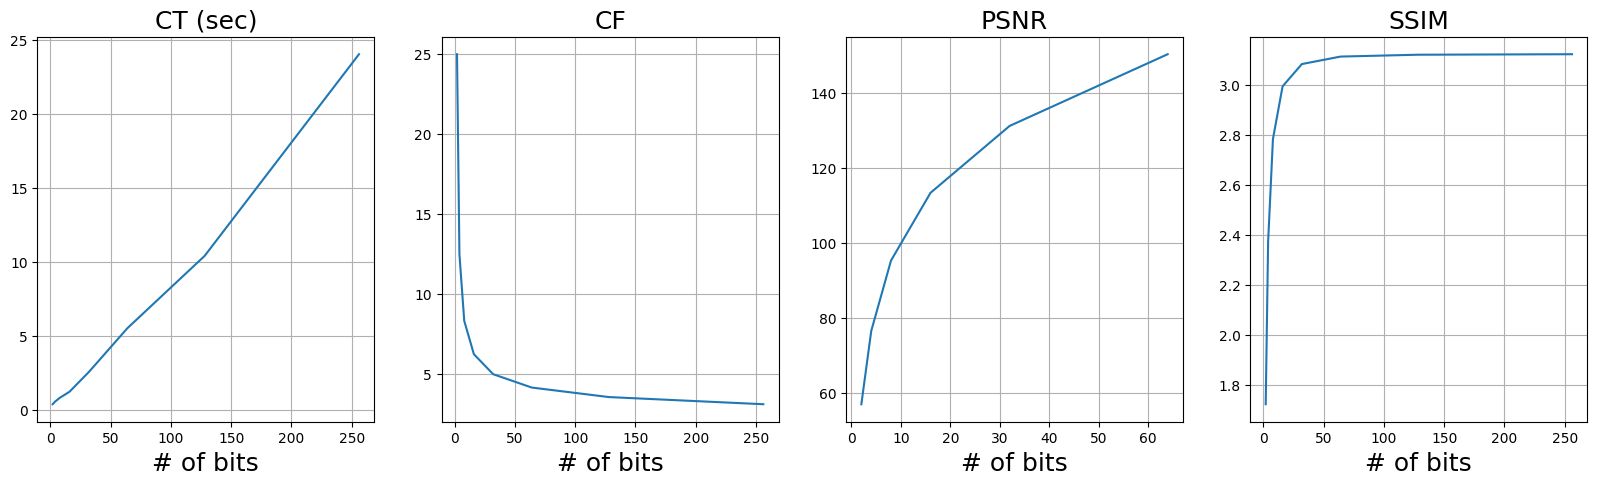

In [53]:
fontsize=18

fig, ax_= plt.subplots(1, 4, figsize=(20, 5))
for metric, ax in zip(["ct", "cf", "psnr", "ssim"], ax_):
    ax.plot(history["parameters"], history[metric])
    ax.set_xlabel(f"# of bits", fontsize=fontsize)
    if metric == "ct":
        ax.set_title(f"{metric.upper()} (sec)", fontsize=fontsize)
    else:
        ax.set_title(f"{metric.upper()}", fontsize=fontsize)
    ax.grid(True)